In [1]:
# Python
import os
import sys
import time
import random
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict

# NumPy and PyTorch
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
class PropagationPath:
    def __init__(self):
        self.points = []
        self.interaction_types = []   # 0 - initial transmitter (radio antenna)   1 - final point (user)   2 - specular reflection   3 - diffraction around the edge
        self.path_gain_db = 0   # dB = 10 * log10(I/I0)   -20 dB = 100 times weaker   -90 dB = 1000000000 times weaker
        self.hash = 0   # hashed set of interactions (objects / surfaces)

offset = 0
def read_int():
    global offset, bytes
    offset += 4
    return bytes[offset-4:offset].copy().view(np.int32)[0]
def read_uint():
    global offset, bytes
    offset += 4
    return bytes[offset-4:offset].copy().view(np.uint32)[0]
def read_float():
    global offset, bytes
    offset += 4
    return bytes[offset-4:offset].copy().view(np.float32)[0]

def read_file(filename: str):
    global offset, bytes
    offset = 0
    bytes = np.fromfile(filename, dtype=np.uint8)

    transmitter_count = read_int()
    paths = []
    for tx in range(transmitter_count):
        receiver_count = read_int()
        paths.append([])
        for rx in range(receiver_count):
            path_count = read_int()
            paths[tx].append([])
            for p in range(path_count):
                path = PropagationPath()
                point_count = read_int()
                for _ in range(point_count):
                    x = read_float()
                    y = read_float()
                    z = read_float()
                    path.points.append((x, y, z))
                for _ in range(point_count):
                    interaction = read_int()
                    path.interaction_types.append(interaction)
                path.path_gain_db = read_float()
                path.hash = read_uint()
                paths[tx][rx].append(path)
    return paths

In [3]:
def init_data(paths, batch_size, ratio):

    all_data = []
    all_hash = []


    for i in range(len(paths)):
      for j in range(len(paths[0])):
        if len(paths[i][j]) != 0:
          for k in paths[i][j]:
            arr = []
            c = 0
            for l in range(len(k.points)):
              c += 1
              for m in range(len(k.points[l])):
                arr.append(k.points[l][m])
            for l in range((5-c)*3, 0, -1):
              arr.append(0)
            for l in range(len(k.interaction_types)):
              arr.append(k.interaction_types[l])
            for l in range(5-c, 0, -1):
              arr.append(0)
            all_hash.append(k.hash)
            arr.append(k.path_gain_db)
            all_data.append(arr)

    #numpy_data = np.array(all_data)

    #rnd_int = np.random.randint(0, len(all_paths))

    data_pairs = []
    tol = 1000000
    for i in range(len(all_data)):
        for j in range(len(all_data)):
            if i != j:  # Ensure the pairs are not identical
                if abs(all_hash[i] - all_hash[j]) < tol:
                  label = 1
                else:
                  label = 0
                data_pairs.append((torch.tensor(all_data[i], dtype=torch.float), torch.tensor(all_data[j], dtype=torch.float), torch.tensor(label, dtype=torch.long)))
        print(len(data_pairs))
        if len(data_pairs) > 1000000:
          break

    dataloaders = DataLoader(data_pairs, batch_size, shuffle=True)
    """
    numpy_data = np.array(data_pairs)

    datasets = {}
    datasets['train'] = np.array(numpy_data[:int(len(numpy_data) * ratio)])
    datasets['val'] = np.array(numpy_data[int(len(numpy_data) * ratio):])


    # Shuffle data
    dataset_length = len(datasets['train'])
    indices = list(range(dataset_length))
    np.random.shuffle(indices)
    sampler = torch.utils.data.SubsetRandomSampler(indices)

    # Create DataLoaders using these samplers
    dataloaders = {
        'train': torch.utils.data.DataLoader(
            datasets['train'],
            batch_size=batch_size,
            sampler=sampler,
            num_workers=2,
            pin_memory=False,
        ),
        'val': torch.utils.data.DataLoader(
            datasets['val'],
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=False,
        )
    }
    """

    return dataloaders

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(21, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 7)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [5]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.PairwiseDistance(p=2)
        distance = euclidean_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        return loss_contrastive

In [6]:
def train_siamese_network(train_loader, net, criterion, optimizer, epochs=1):
    embeddings_list = []
    label_list=[]
    for epoch in range(epochs):
        total_loss=0
        for i, data in enumerate(train_loader, 0):
            input1, input2, label = data
            optimizer.zero_grad()
            output1, output2 = net(input1), net(input2)
            #output1, output2 = net(input1, input2)
            loss = criterion(output1, output2, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            embeddings_list.extend(output1.tolist())  # Store the embeddings in the list
            embeddings_list.extend(output2.tolist())
            #label_list
            label_list.extend(label.tolist())
            if i % 1000 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")
            if i==3000:
              break
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}, Average Loss: {average_loss}")
    return embeddings_list,label_list

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        hidden_size = 15
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, encoding_dim),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def train_autoencoder_network(train_loader, net, criterion, optimizer, epochs=1):
    #This was originally using output of encoder(net.encoder(input)) instead of output of decoder(net(input))
    #which was the reason for another training function
    embeddings_list = []
    label_list=[]
    for epoch in range(epochs):
        total_loss=0
        for i, data in enumerate(train_loader, 0):
            input1, input2, label = data
            optimizer.zero_grad()
            output1, output2 = net(input1), net(input2)
            #output1, output2 = net(input1, input2)
            loss = criterion(output1, output2, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            embeddings_list.extend(output1.tolist())  # Store the embeddings in the list
            embeddings_list.extend(output2.tolist())
            #label_list
            label_list.extend(label.tolist())
            if i % 1000 == 0:
                print(f"Epoch {epoch}, Iteration {i}, Loss {loss.item()}")
            if i==3000:
              break
        average_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}, Average Loss: {average_loss}")
    return embeddings_list,label_list

In [9]:

def plot_pca(embeddings_list):
    # Convert your embeddings list to a NumPy array
    embeddings_array = np.array(embeddings_list)
    #print(embeddings_array)
    # Perform PCA to reduce the dimensionality to 2 or 3 dimensions
    pca = PCA(n_components=2)  # You can choose 3 for 3D visualization
    reduced_embeddings = pca.fit_transform(embeddings_array)

    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', marker='o')
    plt.title("PCA of Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [10]:
path_file = '/mnt/c/Users/Admin/eu_city_2x2_macro_306.bin' # add you path to the file here
paths = read_file(path_file)

# Set random seeds
np.random.seed(0)
batch_size = 10
train_val_ratio = 0.95

In [ ]:
dataloaders = init_data(paths, batch_size, train_val_ratio)

/tmp/ipykernel_84298/2211212982.py:36: RuntimeWarning: overflow encountered in scalar subtract
  if abs(all_hash[i] - all_hash[j]) < tol:


In [99]:
# Instantiate the Siamese Network and Loss Function
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [100]:
embeddings_list,label_list=train_siamese_network(dataloaders, net, criterion, optimizer, epochs=1)

Epoch 0, Iteration 0, Loss 4791.544921875
Epoch 0, Iteration 1000, Loss 16.38865852355957
Epoch 0, Iteration 2000, Loss 5.38086462020874
Epoch 0, Iteration 3000, Loss 3.6952240467071533
Epoch 0, Average Loss: 0.5909881859357217


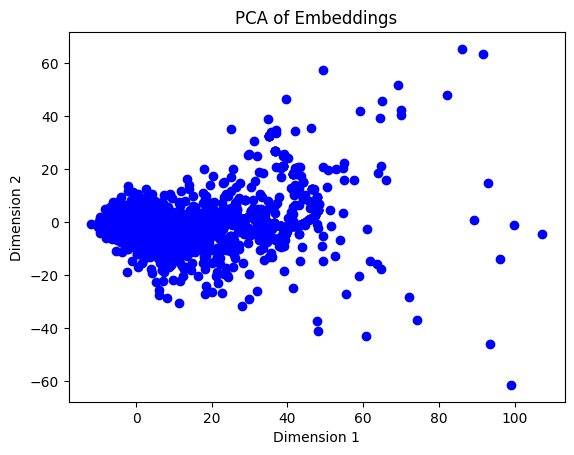

In [102]:
plot_pca(embeddings_list)

In [115]:
# Instantiate the Siamese Network and Loss Function
net = Autoencoder(21,7)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [116]:
embeddings_list,label_list=train_autoencoder_network(dataloaders, net, criterion, optimizer, epochs=1)

Epoch 0, Iteration 0, Loss 761.0965576171875
Epoch 0, Iteration 1000, Loss 1.2614409923553467
Epoch 0, Iteration 2000, Loss 0.08597170561552048
Epoch 0, Iteration 3000, Loss 0.03047420084476471
Epoch 0, Average Loss: 0.24263108485728277


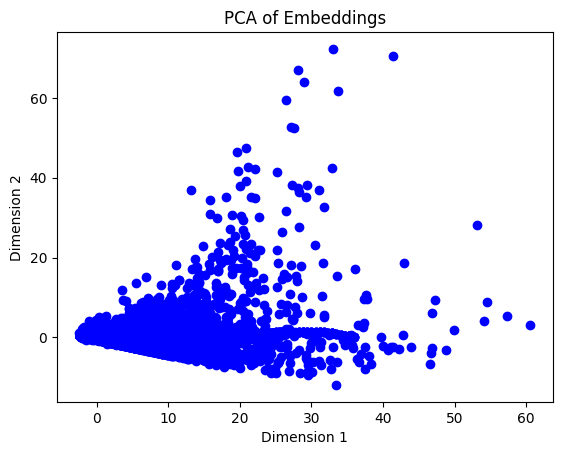

In [117]:
plot_pca(embeddings_list)

In [106]:
def plot_pca2(embeddings_list, labels_list):
    # Convert your embeddings and labels lists to NumPy arrays
    embeddings_array = np.array(embeddings_list)
    labels_array = np.array(labels_list)

    # Perform PCA to reduce the dimensionality to 2 or 3 dimensions
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings_array)

    # Get unique labels
    unique_labels = np.unique(labels_array)

    # Create a dictionary mapping labels to colors
    label_to_color = {label: color for label, color in zip(unique_labels, plt.cm.jet(np.linspace(0, 1, len(unique_labels))))}

    # Create a scatter plot with colored points based on labels
    plt.figure(figsize=(8, 6))
    for label in unique_labels:
        mask = (labels_array == label)
        plt.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], label=f'Label {label}', c=label_to_color[label])

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA of Embeddings with Colored Labels")
    plt.legend()
    plt.show()

In [107]:
# Instantiate the Siamese Network and Loss Function
net = Autoencoder(21,7)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [108]:
embeddings_list,label_list=train_autoencoder_network(dataloaders, net, criterion, optimizer, epochs=1)

Epoch 0, Iteration 0, Loss 1193.0927734375
Epoch 0, Iteration 1000, Loss 6.55911111831665
Epoch 0, Iteration 2000, Loss 0.6485689878463745
Epoch 0, Iteration 3000, Loss 0.24097320437431335
Epoch 0, Average Loss: 1.0085175254410188


In [109]:
plot_pca2(embeddings_list,label_list)

IndexError: ignored

<Figure size 800x600 with 0 Axes>

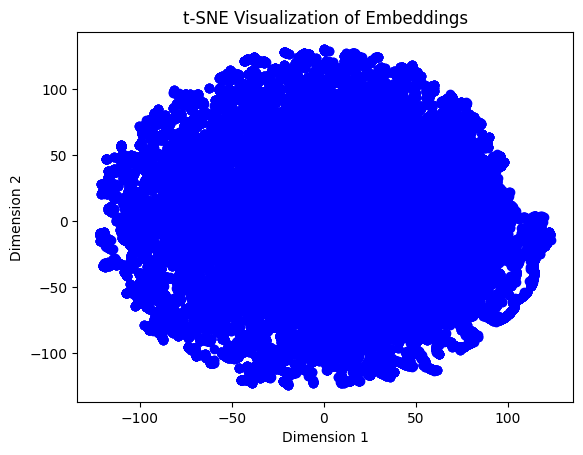

In [37]:
#test tsne takes forever and is a huge blob?
# Convert your embeddings list to a NumPy array
embeddings_array = np.array(embeddings_list)

# Perform t-SNE to reduce the dimensionality to 2 dimensions
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# Create a scatter plot of the reduced embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', marker='o')
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [84]:
all_data = []
all_hash = []
for i in range(len(paths)):
  for j in range(len(paths[0])):
    if len(paths[i][j]) != 0:
      for k in paths[i][j]:
        arr = []
        c = 0
        for l in range(len(k.points)):
          c += 1
          for m in range(len(k.points[l])):
            arr.append(k.points[l][m])
        for l in range((5-c)*3, 0, -1):
          arr.append(0)
        for l in range(len(k.interaction_types)):
          arr.append(k.interaction_types[l])
        for l in range(5-c, 0, -1):
          arr.append(0)
        arr.append(k.path_gain_db)
        all_hash.append(k.hash)
        all_data.append(arr)

In [85]:


"""
hash1 = all_hash[index1]
hash2 = all_hash[index2]

for i in range(len(all_hash)):
  for j in range(len(all_hash)):
    if i != j and all_hash[i] < 3000000000 and all_hash[j] < 3000000000:
      if abs(all_hash[i] - all_hash[j]) < 750000000:
        print("i", i)
        print("hash i", all_hash[i])
        print("j", j)
        print("hash j", all_hash[j])
"""

print(all_hash[0])
print(all_hash[1])
index1 = 0
index2 = 1
print(torch.tensor(all_data[index1]))
print(torch.tensor(all_data[index2]))
print(net(torch.tensor(all_data[index1])))
print(net(torch.tensor(all_data[index2])))
embeddings = net(torch.tensor(all_data[index2]))


3420492267
837731744
tensor([ 158.4912,  -32.5207,   53.3200, -332.8863, -346.3096,   56.2400,
        -342.4107, -352.3864,   56.2400, -371.9333, -369.0092,   23.5096,
           0.0000,    0.0000,    0.0000,    0.0000,    3.0000,    3.0000,
           1.0000,    0.0000, -146.7257])
tensor([ 158.4912,  -32.5207,   53.3200, -342.3768, -341.6233,   56.2400,
        -348.4340, -345.3433,   56.2400, -360.1335, -351.5840,   43.5885,
        -371.9333, -369.0092,   23.5096,    0.0000,    3.0000,    3.0000,
           2.0000,    1.0000, -148.8316])
tensor([ 0.2210, -0.2759,  0.1684, -0.2088,  0.1233, -0.0152, -0.1168,  0.0629,
         0.1720, -0.1215,  0.0173, -0.0394,  0.1598,  0.2615,  0.0686,  0.0833,
         0.0115, -0.1356, -0.1692,  0.1658, -0.2103], grad_fn=<ViewBackward0>)
tensor([ 0.2119, -0.2576,  0.1777, -0.2023,  0.1213, -0.0304, -0.1331,  0.0649,
         0.1720, -0.1254,  0.0223, -0.0342,  0.1617,  0.2408,  0.0970,  0.0665,
         0.0303, -0.1389, -0.1808,  0.1829, -0.2191]

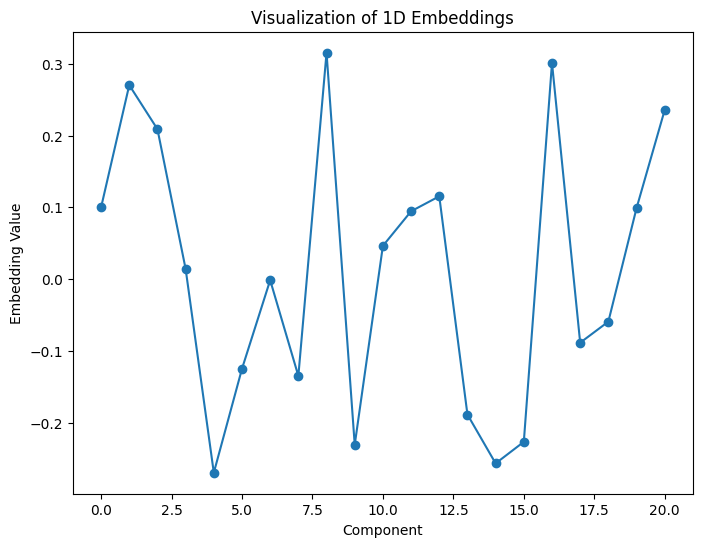

In [17]:
import torch
import matplotlib.pyplot as plt

# Assuming you have the 1D embeddings stored in the 'embeddings' variable

# Convert embeddings to a list
embeddings_list = embeddings.squeeze().tolist()

# Create x-axis indices
indices = list(range(len(embeddings_list)))

# Plot the 1D embeddings
plt.figure(figsize=(8, 6))
plt.plot(indices, embeddings_list, marker='o', linestyle='-')
plt.title('Visualization of 1D Embeddings')
plt.xlabel('Component')
plt.ylabel('Embedding Value')
plt.show()